In [ ]:
!pip uninstall tensorflow

!pip install tensorflow==2.2.0

Uninstalling tensorflow-2.3.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.3.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.3.0
     |████████████████████████████████| 516.2MB 31kB/s 
     |████████████████████████████████| 460kB 45.9MB/s 
     |████████████████████████████████| 3.0MB 44.2MB/s 
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0


In [ ]:
!pip install tqdm
!pip install tqdm --upgrade

     |████████████████████████████████| 71kB 3.6MB/s 
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


## Librerías

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import PIL
import os
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import numpy as np

# TESORFLOW
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Dense, Activation, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, SGD
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from keras import backend as K
import itertools
from keras.models import load_model

from tqdm.keras import TqdmCallback
from numpy.random import seed
seed(11)
tf.random.set_seed(11)

In [ ]:
print("Version: ", tf.__version__)

Version:  2.3.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!unzip '/content/drive/My Drive/TFM/data/datos_antiguos/filtered_img.zip'

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: filtered_img/tt0246262.png  
  inflating: filtered_img/tt0269281.png  
  inflating: filtered_img/tt0011396.png  
  inflating: filtered_img/tt0078320.png  
  inflating: filtered_img/tt0389361.png  
  inflating: filtered_img/tt0092921.png  
  inflating: filtered_img/tt0115682.png  
  inflating: filtered_img/tt0029609.png  
  inflating: filtered_img/tt0123330.png  
  inflating: filtered_img/tt2006093.png  
  inflating: filtered_img/tt0061671.png  
  inflating: filtered_img/tt0953903.png  
  inflating: filtered_img/tt0322082.png  
  inflating: filtered_img/tt0028517.png  
  inflating: filtered_img/tt4799672.png  
  inflating: filtered_img/tt1305714.png  
  inflating: filtered_img/tt0284137.png  
  inflating: filtered_img/tt0201129.png  
  inflating: filtered_img/tt0038704.png  
  inflating: filtered_img/tt3163244.png  
  inflating: filtered_img/tt0227850.png  
  inflating: filtered_img/tt4799114.png  
  inflating: fi

## Importar datos

In [4]:
data_tab = pd.read_csv('/content/drive/My Drive/TFM/data/imdb_data.csv',sep=',',header= 0,usecols=['CODE','RATING'])
data_tab

,CODE,RATING
0,tt4686108,5.3
1,tt0445033,6.4
2,tt1167599,5.5
3,tt4823434,7.0
4,tt0220100,6.0
...,...,...
59620,tt0109540,5.3
59621,tt0119217,8.3
59622,tt0052564,5.3
59623,tt0151309,5.5


In [5]:
data_tab['CODE'] = data_tab['CODE']+ '.png'
data_tab.head()

,CODE,RATING
0,tt4686108.png,5.3
1,tt0445033.png,6.4
2,tt1167599.png,5.5
3,tt4823434.png,7.0
4,tt0220100.png,6.0


Categorizamos la columna Rating


In [6]:
data_tab['RATING']  = data_tab['RATING'].astype(float)
data_tab['RATING'] = pd.cut( data_tab['RATING'], bins = [0,5,6.5,10], labels=['0','1','2'])
data_tab.head(3)

,CODE,RATING
0,tt4686108.png,1
1,tt0445033.png,1
2,tt1167599.png,1


### Metricas custom

In [7]:
def recall_class(y_true, y_pred, class_id):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)

    recall_mask = K.cast(K.equal(class_id_true, class_id), 'int32')
    class_recall_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * recall_mask
    class_recall = K.sum(class_recall_tensor) / K.maximum(K.sum(recall_mask), 1)

    return class_recall

In [8]:
def precision_class(y_true, y_pred, class_id):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)

    precision_mask = K.cast(K.equal(class_id_preds, class_id), 'int32')
    class_prec_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * precision_mask
    class_prec = K.sum(class_prec_tensor) / K.maximum(K.sum(precision_mask), 1)

    return class_prec

In [9]:
def f1_class(y_true, y_pred,class_id):

    class_prec = precision_class(y_true, y_pred, class_id)
    class_recall = recall_class(y_true, y_pred, class_id)
    class_f1 = 2*((class_prec*class_recall)/(class_prec+class_recall+K.epsilon()))

    return class_f1

In [10]:
def precision_total(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = K.cast(true_positives / (predicted_positives + K.epsilon()), 'float64')
    return precision

In [11]:
def custom_metric(y_true, y_pred):
  
  recall_0 = recall_class(y_true, y_pred, 0)
  f1_1 = f1_class(y_true, y_pred,1)
  precision_2 = precision_class(y_true, y_pred, 2)
  total_precision = precision_total(y_true, y_pred)

  metric = (recall_0 + f1_1 + precision_2)/3
  return metric

In [12]:
def custom_metric2(y_true, y_pred):
  
  recall_0 = recall_class(y_true, y_pred, 0)
  f1_1 = f1_class(y_true, y_pred,1)
  precision_2 = precision_class(y_true, y_pred, 2)
  total_precision = precision_total(y_true, y_pred)

  metric = (recall_0 + f1_1 + precision_2 + total_precision)/4
  return metric

### Variables

In [19]:
dim1 = 32    #Dimensiónes de la imagen
dim2 = 32

batch_size = 254

### Image data generator

In [20]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.20)

train_generator=datagen.flow_from_dataframe(
                        dataframe=data_tab,
                        directory="filtered_img/",
                        x_col="CODE",
                        y_col="RATING",
                        subset="training",
                        batch_size=batch_size,
                        seed=42,
                        shuffle=True,
                        class_mode="categorical",
                        target_size=(dim1, dim2),
                        interpolation="nearest")
valid_generator=datagen.flow_from_dataframe(
                        dataframe=data_tab,
                        directory="filtered_img/",
                        x_col="CODE",
                        y_col="RATING",
                        subset="validation",
                        batch_size=batch_size,
                        seed=42,
                        shuffle=True,
                        class_mode="categorical",
                        target_size=(dim1,dim2),
                        interpolation="nearest")

Found 47700 validated image filenames belonging to 3 classes.
Found 11925 validated image filenames belonging to 3 classes.


### Definición del modelo

In [24]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(dim1, dim2, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

conv=model

conv.compile(tf.keras.optimizers.Adam(learning_rate = 0.0001),loss="categorical_crossentropy",metrics=["accuracy",custom_metric,custom_metric2])

### Entrenamiento

In [25]:

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size


model_name = 'conv_model'

es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
mc = ModelCheckpoint('/content/drive/My Drive/Rodrigo/BNvc2'+model_name+'.h5', monitor='val_custom_metric2', mode='max', verbose=0, save_best_only=True,save_weights_only=True)
mc2 = ModelCheckpoint('/content/drive/My Drive/Rodrigo/BNvc1'+model_name+'.h5', monitor='val_custom_metric', mode='max', verbose=0, save_best_only=True,save_weights_only=True)
mc3 = ModelCheckpoint('/content/drive/My Drive/Rodrigo/BNvacc'+model_name+'.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True,save_weights_only=True)
mc4 = ModelCheckpoint('/content/drive/My Drive/Rodrigo/BNvloss'+model_name+'.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True,save_weights_only=True)


history = conv.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10000, verbose=1, callbacks = [es,mc,mc2,mc3,mc4])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10000
  6/187 [..............................] - ETA: 4:57 - loss: 2.2219 - accuracy: 0.3576 - custom_metric: 0.3261 - custom_metric2: 0.3336

KeyboardInterrupt: ignored

### Figuras

In [26]:
conv.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)         

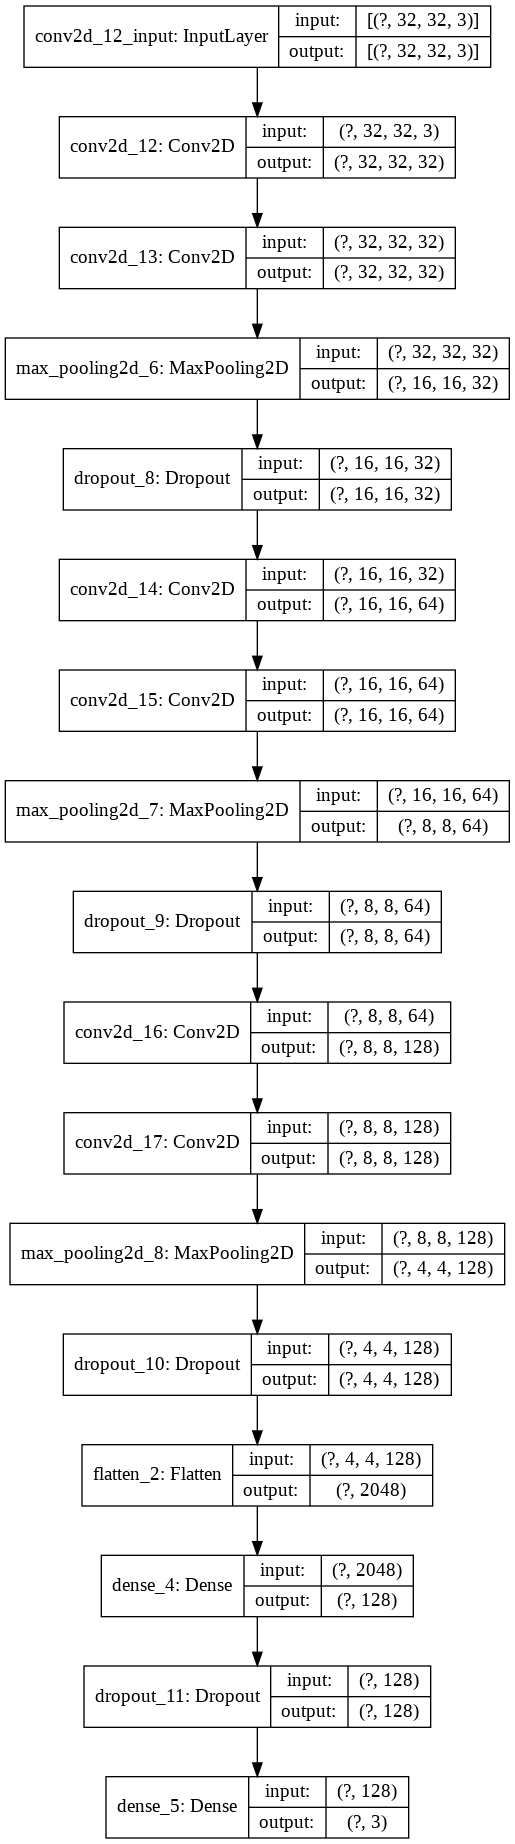

In [27]:
from IPython.display import Image as printModel
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='Multiinput.png',show_shapes=True,show_layer_names=True)
printModel(retina=True, filename='Multiinput.png')

### Métricas de los checkpoints

In [ ]:
conv.load_weights('/content/drive/My Drive/Máster KSchool/TFM/Codigos/Img classification/BNvc13232p1-6p2-8.h5')

In [ ]:
loss, acc, score,score2 = conv.evaluate_generator(valid_generator)

In [ ]:
print('val_loss:',loss,'- val_accuracy:',acc,'- val_custom_metric:',score,'- val_custom_metric2:',score2)

val_loss: 1.0246598720550537 - val_accuracy: 0.4520754814147949 - val_custom_metric: 0.4365004599094391 - val_custom_metric2: 0.4471881687641144


### Guardado para la app

In [ ]:
conv.save('Modelo_imagenes_App.h5')

In [ ]:
model = load_model('Modelo_imagenes_App.h5',custom_objects={'custom_metric':custom_metric,'custom_metric2':custom_metric2},compile=False)
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics=["accuracy"])

In [ ]:
loss, acc, score,score2 = model.evaluate_generator(valid_generator,steps = nb_samples)

In [ ]:
print('val_loss:',loss,'- val_accuracy:',acc,'- val_custom_metric:',score,'- val_custom_metric2:',score2)

val_loss: 1.0246599912643433 - val_accuracy: 0.4520754814147949 - val_custom_metric: 0.4369473159313202 - val_custom_metric2: 0.4479353427886963


In [ ]:
model.save('/content/drive/My Drive/TFM/Codigos/Modelos_Arquitecturas_clasificación/Images_Modelo')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/TFM/Codigos/Modelos_Arquitecturas_clasificación/Images_Modelo/assets


### Mas métricas

In [ ]:
n_batches = len(valid_generator)

matrix = confusion_matrix(
    np.concatenate([np.argmax(valid_generator[i][1], axis=1) for i in range(n_batches)]),    
    np.argmax(model.predict_generator(valid_generator, steps=n_batches), axis=1) 
)

In [ ]:
matrix = confusion_matrix(np.array(valid_generator.classes), y_pred.argmax(axis=1))

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
target_names = ['0-5', '5-6.5', '6.5-10']

Confusion matrix, without normalization
[[ 590 1331  247]
 [ 628 3681  948]
 [ 399 2981 1120]]


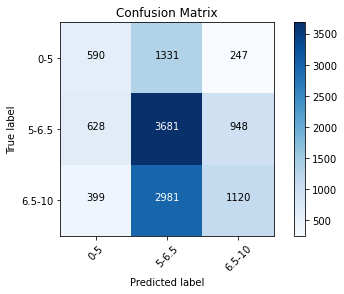

In [ ]:
plot_confusion_matrix(cm=matrix, classes=target_names, title='Confusion Matrix')

In [ ]:
print(classification_report(
    np.concatenate([np.argmax(valid_generator[i][1], axis=1) for i in range(n_batches)]),    
    np.argmax(model.predict_generator(valid_generator, steps=n_batches), axis=1),target_names=target_names 
))

              precision    recall  f1-score   support

         0-5       0.36      0.27      0.31      2168
       5-6.5       0.46      0.70      0.56      5257
      6.5-10       0.48      0.25      0.33      4500

    accuracy                           0.45     11925
   macro avg       0.44      0.41      0.40     11925
weighted avg       0.45      0.45      0.43     11925

